In [10]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

Current notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset
Added /home/luky/skola/KalmanNet-main to sys.path


In [11]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device  # For backward compatibility
print(f"device: {device}")

device: cuda


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import Systems


# Parametry sekvencí
TRAIN_SEQ_LEN = 50       # Délka sekvence pro trénink (např. 100 kroků = 100 sekund při 1Hz)
VAL_SEQ_LEN = 200
TEST_SEQ_LEN = 1000      # Délka sekvence pro testování (delší sekvence pro stabilnější vyhodnocení)
STRIDE = 20         # Posun okna (překryv) pro data augmentation
BATCH_SIZE = 256
DATA_PATH = 'data/processed'
print(f"Běží na zařízení: {device}")

Běží na zařízení: cuda


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os

def prepare_sequences(dataset_list, seq_len, stride, mode='train'):
    """
    Zpracuje list trajektorií na sekvence pro trénink dle článku.
    
    Nový formát dle [Song et al., 2024]:
    - Vstup u (4D): [v_left, v_right, theta_imu, omega_imu]
    - Cíl x (6D):   [px, py, vx, vy, theta, omega]
    """
    X_seq_list = [] # Ground Truth (Cíl)
    Y_seq_list = [] # GPS Měření (Vstup do korekce)
    U_seq_list = [] # Control Input (IMU/Odo)
    
    print(f"Zpracovávám {len(dataset_list)} trajektorií pro {mode}...")
    
    for traj in dataset_list:
        # 1. Extrahuje data
        # GT z preprocessingu je [px, py, theta]
        gt = traj['ground_truth'].float() 
        
        # GPS: [x, y] (obsahuje NaN!)
        gps = traj['filtered_gps'].float()
        
        # IMU: [ax, ay, theta, omega]
        imu = traj['imu'].float()
        theta_imu = imu[:, 2] # Orientace z IMU
        omega_imu = imu[:, 3] # Úhlová rychlost z IMU
        
        # ODO: [v_left, v_right]
        odo = traj['filtered_wheel'].float()
        
        # Fix NaN v odometrii (nahradíme nulou)
        v_left = torch.nan_to_num(odo[:, 0], nan=0.0)
        v_right = torch.nan_to_num(odo[:, 1], nan=0.0)
        
        # 2. Sestavení vstupu u = [v_l, v_r, theta_imu, omega_imu] (4D)
        # Toto odpovídá "State Model" definovanému v článku (sekce II.C.2)
        u = torch.stack((v_left, v_right, theta_imu, omega_imu), dim=1)
        
        # 3. Sestavení cíle x (6D) pro state vector [px, py, vx, vy, theta, omega]
        # Vyplníme to, co máme z Ground Truth (px, py, theta).
        # Rychlosti (vx, vy, omega) v GT implicitně nemáme (nebo je složité je derivovat přesně),
        # ale pro trénink Loss funkce budeme stejně porovnávat primárně pozici.
        T = gt.shape[0]
        x_target = torch.zeros(T, 6)
        x_target[:, 0] = gt[:, 0] # px
        x_target[:, 1] = gt[:, 1] # py
        x_target[:, 4] = gt[:, 2] # theta
        # Ostatní (vx, vy, omega) zůstávají 0, protože v Loss funkci budeme maskovat nebo brát jen pozici.
        
        # 4. Sliding Window (Rozsekání na sekvence)
        num_samples = gt.shape[0]
        current_stride = stride if mode == 'train' else seq_len # U testu bez překryvu
        
        for i in range(0, num_samples - seq_len + 1, current_stride):
            # Cíl: 6D stav
            x_seq = x_target[i : i+seq_len, :]
            
            # Měření: GPS [px, py]
            y_seq = gps[i : i+seq_len, :]
            
            # Vstup: 4D control input
            u_seq = u[i : i+seq_len, :]
            
            X_seq_list.append(x_seq)
            Y_seq_list.append(y_seq)
            U_seq_list.append(u_seq)
            
    # Stack do tenzorů
    X_out = torch.stack(X_seq_list)
    Y_out = torch.stack(Y_seq_list)
    U_out = torch.stack(U_seq_list)
    
    return X_out, Y_out, U_out

# === NAČTENÍ DAT ===
# Ujistíme se, že cesty a konstanty jsou definované (pokud nejsou, doplňte je nahoře)
# if 'DATA_PATH' not in locals(): DATA_PATH = 'data/processed'
# if 'TRAIN_SEQ_LEN' not in locals(): TRAIN_SEQ_LEN = 100
# if 'VAL_SEQ_LEN' not in locals(): VAL_SEQ_LEN = 200
# if 'TEST_SEQ_LEN' not in locals(): TEST_SEQ_LEN = 500
# if 'STRIDE' not in locals(): STRIDE = 20
# if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 256

train_data_raw = torch.load(os.path.join(DATA_PATH, 'train.pt'))
val_data_raw = torch.load(os.path.join(DATA_PATH, 'val.pt'))
test_data_raw = torch.load(os.path.join(DATA_PATH, 'test.pt'))
# Načtení celého balíku
# train_data_full = torch.load(os.path.join(DATA_PATH, 'train.pt'))

# === RYCHLÝ TEST: OŘÍZNUTÍ DAT ===
# Vezmeme jen prvních 5 trajektorií z 22. 
# To radikálně zrychlí jednu epochu a umožní rychle otestovat stabilitu hyperparametrů.
# train_data_raw = train_data_full[:10] 

print(f"DEBUG: Pro rychlý test používám jen {len(train_data_raw)} trajektorií.")
# ... zbytek kódu beze změny

# === PŘÍPRAVA SEKVENCÍ ===
print("--- Generuji trénovací data (Paper compatible) ---")
train_X, train_Y, train_U = prepare_sequences(train_data_raw, TRAIN_SEQ_LEN, STRIDE, 'train')

print("\n--- Generuji validační data ---")
val_X, val_Y, val_U = prepare_sequences(val_data_raw, VAL_SEQ_LEN, VAL_SEQ_LEN, 'val')

print("\n--- Generuji testovací data ---")
test_X, test_Y, test_U = prepare_sequences(test_data_raw, TEST_SEQ_LEN, TEST_SEQ_LEN, 'test')

# Vytvoření DataLoaderů
train_loader = DataLoader(TensorDataset(train_X, train_Y, train_U), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_Y, val_U), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(test_X, test_Y, test_U), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ Data připravena.")
print(f"Train batches: {len(train_loader)}")
print(f"Shapes -> X: {train_X.shape} (6D State), U: {train_U.shape} (4D Input), Y: {train_Y.shape} (2D Meas)")

DEBUG: Pro rychlý test používám jen 22 trajektorií.
--- Generuji trénovací data (Paper compatible) ---
Zpracovávám 22 trajektorií pro train...

--- Generuji validační data ---
Zpracovávám 2 trajektorií pro val...

--- Generuji testovací data ---
Zpracovávám 3 trajektorií pro test...

✅ Data připravena.
Train batches: 22
Shapes -> X: torch.Size([5504, 50, 6]) (6D State), U: torch.Size([5504, 50, 4]) (4D Input), Y: torch.Size([5504, 50, 2]) (2D Meas)


In [14]:
# === INICIALIZACE DYNAMICKÉHO MODELU (System Instance - Paper Version) ===

# 1. Parametry systému podle článku [Song et al., 2024]
# State (6D): [px, py, vx, vy, theta, omega]
# Referenční rovnice (5) v článku.
state_dim = 6
# Meas (2D):  [gps_x, gps_y]
# Referenční rovnice (6) v článku.
obs_dim = 2
# Časový krok (z preprocessingu)
dt = 1.0  

# 2. Definice Matice Q (Procesní šum / Model Uncertainty)
# Nyní máme 6 stavů. Musíme definovat nejistotu pro každý z nich.
# Hodnoty jsou nastaveny heuristicky (lze ladit):
# - Pozice (idx 0,1): 0.1
# - Rychlost (idx 2,3): 0.1
# - Úhel/Omega (idx 4,5): 0.01 (IMU je v NCLT docela přesné, ale driftuje)
q_diag = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])
Q = torch.diag(q_diag)

# 3. Definice Matice R (Šum měření / Sensor Noise)
# GPS měří jen pozici (px, py).
# Nastavujeme 1.0 m^2. To odpovídá standardní odchylce 1m.
# Pokud je GPS v datasetu horší, KalmanNet se naučí "nedůvěřovat" vstupu y
# a spoléhat více na predikci z u (odometrie).
r_diag = torch.tensor([1.0, 1.0])
R = torch.diag(r_diag)

# 4. Počáteční podmínky (Prior)
# Ex0: Nulový vektor 6x1
Ex0 = torch.zeros(state_dim, 1)

# P0: Počáteční kovariance
# Autoři používají P k inicializaci EKF[cite: 700].
# Nastavíme rozumnou počáteční nejistotu.
P0 = torch.eye(state_dim) * 0.5

# 5. Vytvoření instance DynamicSystemNCLT
# Důležité: f=None zajistí, že se použije interní `_f_paper_dynamics` (rovnice 5),
# která očekává 4D vstup (v_l, v_r, theta, omega).
sys_model = Systems.DynamicSystemNCLT(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q,
    R=R,
    Ex0=Ex0,
    P0=P0,
    dt=dt,
    f=None,  # None -> Použije se model z článku: px += vc*cos(theta_imu)...
    h=None,  # None -> Použije se GPS model: y = [px, py]
    device=DEVICE
)

print(f"✅ System Model NCLT inicializován (Paper Version).")
print(f" - State Dim: {sys_model.state_dim} [px, py, vx, vy, theta, omega]")
print(f" - Meas Dim:  {sys_model.obs_dim} [gps_x, gps_y]")
print(f" - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]") # Implicitně v modelu
print(f" - Q Diag: {q_diag.tolist()}")

✅ System Model NCLT inicializován (Paper Version).
 - State Dim: 6 [px, py, vx, vy, theta, omega]
 - Meas Dim:  2 [gps_x, gps_y]
 - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]
 - Q Diag: [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.009999999776482582, 0.009999999776482582]


In [15]:
import torch
import torch.optim as optim
import os
from state_NN_models import NCLT
from utils import trainer

state_knet = NCLT.StateKalmanNetNCLT(
    system_model=sys_model,
    device=DEVICE,
    hidden_size_multiplier=8,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    gru_hidden_dim_multiplier=8
).to(DEVICE)

print(state_knet)

# state_bkn = NCLT.StateBayesianKalmanNetNCLT(
#     system_model=sys_model,
#     device=DEVICE,
#     hidden_size_multiplier=8,      # Větší kapacita pro složitější dynamiku
#     output_layer_multiplier=4,
#     num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
#     init_min_dropout=0.2,
#     init_max_dropout=0.4
# ).to(DEVICE)

# state_bkn = NCLT.StateBayesianKalmanNetNCLT_test(
#     system_model=sys_model,
#     device=DEVICE,
#     hidden_size_multiplier=10,      # Větší kapacita pro složitější dynamiku
#     output_layer_multiplier=4,
#     num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
#     init_min_dropout=0.4,
#     init_max_dropout=0.6
# ).to(DEVICE)
# print(state_bkn)
JITTER_VECTOR = [
    1.5,   # px: 20 cm nejistota v poloze (prokluz)
    1.5,   # py: 20 cm
    0.5,   # vx: 10 cm/s šum rychlosti
    0.5,   # vy: 10 cm/s
    0.06,  # theta: ~1 stupeň (klíčové pro zatáčení trajektorií!)
    0.02   # omega: malý šum
]
state_bkn = NCLT.StateBayesianKalmanNetNCLT_Diagnostic(
    system_model=sys_model,
    device=DEVICE,
    hidden_size_multiplier=10,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    init_min_dropout=0.3,
    init_max_dropout=0.4,
    process_jitter=JITTER_VECTOR
).to(DEVICE)
print(state_bkn)

kalman_former = NCLT.KalmanFormerNCLT(
    system_model=sys_model,
    device=DEVICE,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.25
).to(DEVICE)

print(kalman_former)


DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNetNCLT(
  (dnn): DNN_KalmanNetNCLT(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
    )
    (gru): GRU(512, 320)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=320, out_features=48, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=48, out_features=12, bias=True)
    )
  )
)
INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).
StateBayesianKalmanNetNCLT_Diagnostic(
  (dnn): DNN_BayesianKalmanNetNCLT_test(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (concrete_dropout1): ConcreteDropout()
    (gru): GRU(640, 160)
    (output_layer): Sequential(
      (0): Linear(in_features=160, out_features=48, bias=True)
      (1): ReLU()
      (2): Li

In [16]:
import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'NN_weights/complex'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'best_Knet_test_results.pth'
# BKN_FILENAME = 'best_BKN_test_results_legal.pth'                                            # Doplň název
BKN_FILENAME = 'BKN_aggresive_jitter.pth'                                            # Doplň název
FORMER_FILENAME = 'best_KalmanFormer_test_results.pth'                                # Doplň název

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=DEVICE)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet, KNET_FILENAME, "State KalmanNet")

# Načtení Bayesian KalmanNet
load_pretrained_weights(state_bkn, BKN_FILENAME, "State BKN")

# Načtení KalmanFormer
load_pretrained_weights(kalman_former, FORMER_FILENAME, "KalmanFormer")

print("\n--- Hotovo ---")

--- Načítání vah ze složky: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/NN_weights/complex ---

✅ State KalmanNet: Váhy úspěšně načteny z 'best_Knet_test_results.pth'.
✅ State BKN: Váhy úspěšně načteny z 'BKN_aggresive_jitter.pth'.
✅ KalmanFormer: Váhy úspěšně načteny z 'best_KalmanFormer_test_results.pth'.

--- Hotovo ---


INFO: Nastaveno sys_model.dt = 1.0 s
INFO: BKN připraven (J=50).
INFO: KalmanNet připraven.
INFO: KalmanFormer připraven.
Initialized Adaptive APF: N=50000, Jitter=2.0, R-Infl=100.0, ResampleThr=0.25
INFO: Particle Filter připraven (N=100000).

Spouštím evaluaci na 3 trajektoriích...
Traj 1 | RMSE [m]: EKF:21.05, UKF:20.99, PF:17.64, KNet:12.78, BKN:14.82, Form:16.69


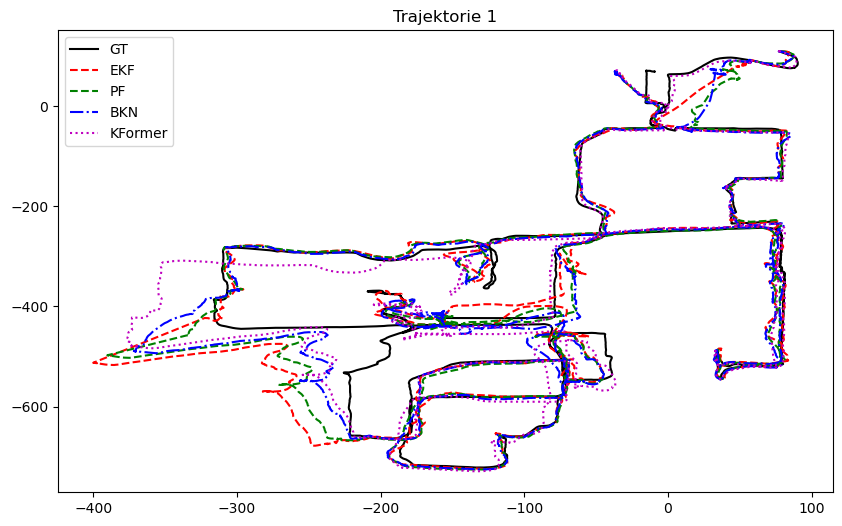

Traj 2 | RMSE [m]: EKF:14.89, UKF:14.89, PF:9.32, KNet:6.68, BKN:7.31, Form:9.01


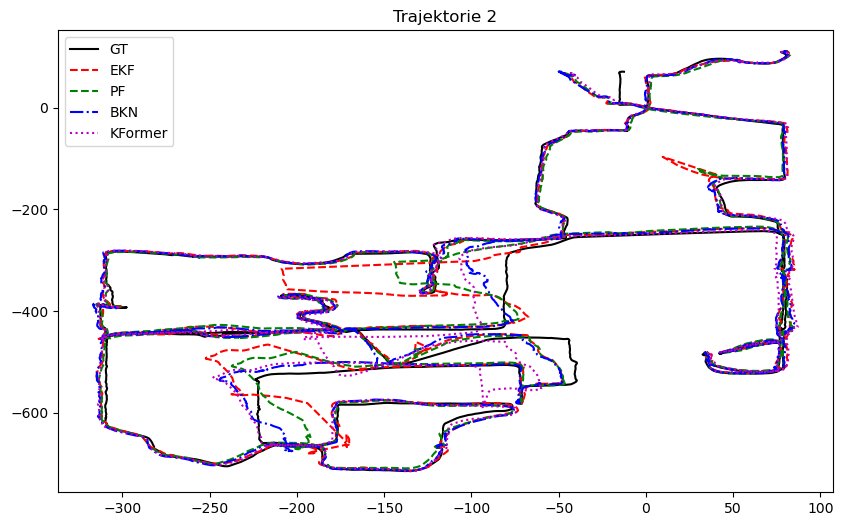

Traj 3 | RMSE [m]: EKF:11.33, UKF:11.34, PF:7.86, KNet:6.07, BKN:7.50, Form:5.87


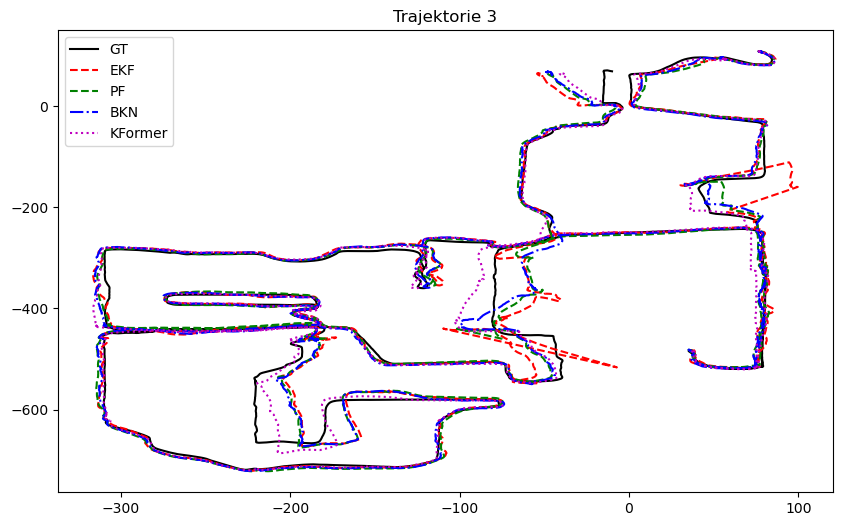


                                        TABULKA 1: Detailní výsledky po trajektoriích                                        
ID   | EKF MSE   ANEES   | UKF MSE   ANEES   | PF MSE    ANEES   | BKN MSE   ANEES   | KNet MSE  | Form MSE 
-----------------------------------------------------------------------------------------------------------------------------
1    | 443.11    1004.45 | 440.44    1004.18 | 311.18    52.07   | 219.49    43.07   | 163.35    | 278.58   
2    | 221.68    417.55  | 221.82    417.55  | 86.91     18.72   | 53.40     27.16   | 44.64     | 81.13    
3    | 128.44    281.52  | 128.70    281.54  | 61.80     10.70   | 56.30     26.55   | 36.83     | 34.46    

                  TABULKA 2: Souhrnné průměrné výsledky (Mean across trajectories)                  
Metoda          | MSE (avg)    | RMSE (avg)   | ANEES (avg) 
----------------------------------------------------------------------------------------------------
GPS             | 1225.21      | 35.00        |

/tmp/ipykernel_28606/1931642208.py:331: RuntimeWarning: Mean of empty slice
  mean_anees = np.nanmean(anees_list)


In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys

# ==============================================================================
# 0. KONFIGURACE A MODEL
# ==============================================================================
DT_SEC = 1.0 
J_SAMPLES = 50  # Počet vzorků pro BKN (MC Dropout)
NUM_PARTICLES = 100000 # Počet částic pro PF

if hasattr(sys_model, 'dt'):
    sys_model.dt = DT_SEC
    print(f"INFO: Nastaveno sys_model.dt = {DT_SEC} s")

# --- KONTROLA A PŘÍPRAVA NN MODELŮ ---
models_to_eval = {}

# 1. Bayesian KalmanNet
try:
    state_bkn.eval()
    models_to_eval['BKN'] = state_bkn
    print(f"INFO: BKN připraven (J={J_SAMPLES}).")
except NameError:
    print("WARNING: 'state_bkn' nenalezen.")

# 2. State KalmanNet (Standard)
try:
    state_knet.eval()
    models_to_eval['KNet'] = state_knet
    print("INFO: KalmanNet připraven.")
except NameError:
    print("WARNING: 'state_knet' nenalezen.")

# 3. KalmanFormer
try:
    kalman_former.eval()
    models_to_eval['KFormer'] = kalman_former
    print("INFO: KalmanFormer připraven.")
except NameError:
    print("WARNING: 'kalman_former' nenalezen.")

from Filters import NCLT

# --- INICIALIZACE KLASICKÝCH FILTRŮ ---
ukf_filter = NCLT.UnscentedKalmanFilterNCLT(sys_model) 
ekf_filter = NCLT.ExtendedKalmanFilterNCLT(sys_model)

# Inicializace PF (používáme opravenou třídu z minula)
try:
    pf_filter = NCLT.AuxiliaryParticleFilterNCLT(
    sys_model, 
    num_particles=50000, 
    jitter_strength=2.0,   # Pokud je MSE dobré, neměňte. Pokud je moc velké, zkuste 1.5.
    r_inflation=100.0,      # Zvyšte, pokud je ANEES stále > 100. Zkuste 20, 50, 100.
    resample_threshold=0.25 # Standardní hodnota (50 % efektivních částic)
)
    print(f"INFO: Particle Filter připraven (N={NUM_PARTICLES}).")
except NameError:
    print("ERROR: Třída AuxiliaryParticleFilterNCLT nenalezena! Ujisti se, že je definována.")
    pf_filter = None

# ==============================================================================
# --- ROBUSTNÍ FUNKCE PRO ANEES (OPRAVENÁ) ---
# ==============================================================================
def calculate_anees_correct(x_true, x_est, P_est, indices):
    """
    Vypočte ANEES se správným výběrem indexů a ošetřením úhlů.
    x_true: [T, 3] (GT: px, py, theta)
    x_est:  [T, 6] (Est: px, py, vx, vy, theta, omega)
    P_est:  [T, 6, 6]
    indices: list indexů v x_est, které odpovídají x_true (např. [0, 1, 4])
    """
    T = x_true.shape[0]
    anees_list = []
    
    # 1. Výběr relevantních stavů z odhadu
    # x_est má shape [T, 6], chceme [T, 3] odpovídající [px, py, theta]
    x_est_selected = x_est[:, indices]
    
    # 2. Výběr relevantních částí kovariance
    # P_est má [T, 6, 6], chceme submatici [T, 3, 3] pro indices
    # P[:, indices][:, :, indices] vybere správnou submatici
    # Pozor: V PyTorch musíme indexovat opatrně
    P_est_selected = P_est[:, indices][:, :, indices]
    
    # 3. Výpočet chyby
    error = x_true - x_est_selected
    
    # 4. WRAPPING ÚHLU (předpokládáme, že poslední dimenze GT je úhel theta)
    # Chyba úhlu musí být v intervalu [-pi, pi]
    # error[:, 2] je chyba thety (protože x_true je 3D)
    angle_err = error[:, 2]
    angle_err = (angle_err + np.pi) % (2 * np.pi) - np.pi
    error[:, 2] = angle_err
    
    for t in range(T):
        e_t = error[t].unsqueeze(1) # [3, 1]
        P_t = P_est_selected[t]     # [3, 3]
        
        try:
            # Používáme pinv pro numerickou stabilitu
            P_inv = torch.linalg.pinv(P_t, hermitian=True)
        except RuntimeError:
            P_inv = torch.eye(P_t.shape[0], device=P_t.device)
        
        # Mahalanobisova vzdálenost^2
        nees = torch.mm(torch.mm(e_t.t(), P_inv), e_t).item()
        anees_list.append(nees)
        
    return np.mean(anees_list)

def get_mse(pred, target):
    return F.mse_loss(pred[:, :2], target[:, :2]).item()

# ==============================================================================
# 1. EVALUACE TRAJEKTORIÍ
# ==============================================================================
# Úložiště výsledků pro finální tabulku
metrics_storage = {
    'BKN': {'MSE': [], 'ANEES': []},
    'EKF': {'MSE': [], 'ANEES': []},
    'UKF': {'MSE': [], 'ANEES': []},
    'PF':  {'MSE': [], 'ANEES': []},
    'KNet': {'MSE': [], 'ANEES': []},   # ANEES bude vždy NaN
    'KFormer': {'MSE': [], 'ANEES': []}, # ANEES bude vždy NaN
    'GPS': {'MSE': [], 'ANEES': []}
}

# Definice mapování indexů: Est [px, py, vx, vy, theta, omega] -> GT [px, py, theta]
# Bereme px(0), py(1) a theta(4)
STATE_INDICES_MAPPING = [0, 1, 4]

print(f"\nSpouštím evaluaci na {len(test_data_raw)} trajektoriích...")

for i, traj in enumerate(test_data_raw):
    # --- PŘÍPRAVA DAT ---
    gt_raw = traj['ground_truth'].float().to(DEVICE)
    gps_filtered = traj['filtered_gps'].float().to(DEVICE) # S NaNs
    imu_raw = traj['imu'].float().to(DEVICE)
    odo_raw = traj['filtered_wheel'].float().to(DEVICE)
    T_len = gt_raw.shape[0]
    
    if 'gps' in traj:
        gps_raw_metric = traj['gps'].float().to(DEVICE)
    else:
        gps_raw_metric = gps_filtered # Fallback
        
    # Input vector [v_left, v_right, ax, ay]
    u_full = torch.stack((
        torch.nan_to_num(odo_raw[:, 0], nan=0.0),
        torch.nan_to_num(odo_raw[:, 1], nan=0.0),
        imu_raw[:, 2], 
        imu_raw[:, 3]
    ), dim=1).to(DEVICE)
    
    # Ground Truth State (X, Y, Theta)
    x_true = gt_raw[:, :3] 
    
    # Init pro filtry
    m = sys_model.state_dim
    x0_vec = torch.zeros(m).to(DEVICE)
    x0_vec[0] = x_true[0, 0]; x0_vec[1] = x_true[0, 1]
    if m >= 3 and x_true.shape[1] >= 3: x0_vec[4] = x_true[0, 2] 
    x0_batch = x0_vec.unsqueeze(0)

    # --------------------------------------------------------------------------
    # A. BĚH MODELŮ S NEJISTOTOU (BKN, EKF, UKF, PF)
    # --------------------------------------------------------------------------
    
    # 1. BKN (Bayesian KalmanNet)
    x_bkn_mean, P_bkn = None, None
    if 'BKN' in models_to_eval:
        models_to_eval['BKN'].train() 
        batch_x0_bkn = x0_vec.unsqueeze(0).repeat(J_SAMPLES, 1)
        models_to_eval['BKN'].reset(batch_size=J_SAMPLES, initial_state=batch_x0_bkn)
        
        bkn_samples = [batch_x0_bkn.unsqueeze(1)]
        with torch.no_grad():
            for t in range(1, T_len):
                y_t = gps_filtered[t].unsqueeze(0).repeat(J_SAMPLES, 1)
                u_t = u_full[t].unsqueeze(0).repeat(J_SAMPLES, 1)
                x_est_j, _ = models_to_eval['BKN'].step(y_t, u_t)
                bkn_samples.append(x_est_j.unsqueeze(1))
        
        bkn_ensemble = torch.cat(bkn_samples, dim=1) # [J, T, m]
        x_bkn_mean = torch.mean(bkn_ensemble, dim=0) 
        
        # Covariance approx
        centered = bkn_ensemble - x_bkn_mean.unsqueeze(0)
        centered_perm = centered.permute(1, 2, 0) 
        P_bkn = torch.bmm(centered_perm, centered_perm.transpose(1, 2)) / (J_SAMPLES - 1)
        # Malá regularizace pro BKN je ok, ale nesmí nahrazovat nejistotu
        P_bkn = P_bkn + torch.eye(m, device=DEVICE).unsqueeze(0) * 1e-6 
        models_to_eval['BKN'].eval()

    # 2. & 3. EKF & UKF
    def run_filter(flt):
        try:
            res = flt.process_sequence(gps_filtered, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
            return res['x_filtered'], res.get('P_filtered', None)
        except Exception as e:
            return torch.zeros(T_len, m).to(DEVICE), None

    x_ekf, P_ekf = run_filter(ekf_filter)
    x_ukf, P_ukf = run_filter(ukf_filter)
    
    # 4. Particle Filter
    x_pf, P_pf = None, None
    if pf_filter is not None:
        try:
            res_pf = pf_filter.process_sequence(gps_filtered, u_sequence=u_full, Ex0=x0_vec, P0=sys_model.P0)
            x_pf = res_pf['x_filtered']
            P_pf = res_pf['P_filtered']
        except Exception as e:
            print(f"PF Error: {e}")
            x_pf = torch.zeros(T_len, m).to(DEVICE)

    # --------------------------------------------------------------------------
    # B. BĚH MODELŮ BEZ NEJISTOTY (KNet, KFormer)
    # --------------------------------------------------------------------------
    
    def run_nn_simple(model):
        model.reset(batch_size=1, initial_state=x0_batch)
        path = [x0_batch]
        with torch.no_grad():
            for t in range(1, T_len):
                x_step = model.step(gps_filtered[t].unsqueeze(0), u_full[t].unsqueeze(0))
                path.append(x_step)
        return torch.cat(path, dim=0)

    x_knet = run_nn_simple(models_to_eval['KNet']) if 'KNet' in models_to_eval else None
    x_former = run_nn_simple(models_to_eval['KFormer']) if 'KFormer' in models_to_eval else None

    # --------------------------------------------------------------------------
    # C. VYHODNOCENÍ METRIK (OPRAVENO)
    # --------------------------------------------------------------------------
    
    def calc_metrics(name, est_x, est_P=None):
        if est_x is None: return np.nan, np.nan
        
        # 1. MSE
        mse_val = get_mse(est_x, x_true)
        metrics_storage[name]['MSE'].append(mse_val)
        
        # 2. ANEES (jen pokud máme P)
        anees_val = np.nan
        if est_P is not None:
            # POUŽITÍ OPRAVENÉ FUNKCE S INDEXY
            if x_true.shape[1] == 3 and est_x.shape[1] >= 5:
                anees_val = calculate_anees_correct(x_true, est_x, est_P, STATE_INDICES_MAPPING)
            else:
                print(f"Warning: Nesedí dimenze pro ANEES u {name}. True: {x_true.shape}, Est: {est_x.shape}")
            metrics_storage[name]['ANEES'].append(anees_val)
        else:
            metrics_storage[name]['ANEES'].append(np.nan) 
            
        return mse_val, anees_val

    # Výpočet pro všechny
    mse_bkn, anees_bkn = calc_metrics('BKN', x_bkn_mean, P_bkn)
    mse_ekf, anees_ekf = calc_metrics('EKF', x_ekf, P_ekf)
    mse_ukf, anees_ukf = calc_metrics('UKF', x_ukf, P_ukf)
    mse_pf, anees_pf   = calc_metrics('PF', x_pf, P_pf)
    mse_knet, _        = calc_metrics('KNet', x_knet, None)
    mse_form, _        = calc_metrics('KFormer', x_former, None)

    # GPS Metriky
    mse_gps = F.mse_loss(gps_raw_metric[:, :2], x_true[:, :2]).item()
    metrics_storage['GPS']['MSE'].append(mse_gps)
    
    # --------------------------------------------------------------------------
    # D. VÝPIS PO TRAJEKTORII
    # --------------------------------------------------------------------------
    print(f"Traj {i+1} | RMSE [m]: EKF:{np.sqrt(mse_ekf):.2f}, UKF:{np.sqrt(mse_ukf):.2f}, PF:{np.sqrt(mse_pf):.2f}, KNet:{np.sqrt(mse_knet):.2f}, BKN:{np.sqrt(mse_bkn):.2f}, Form:{np.sqrt(mse_form):.2f}")

    fig, ax = plt.subplots(figsize=(10, 6))
    gt = x_true.cpu().numpy()
    ax.plot(gt[:,0], gt[:,1], 'k-', label='GT')
    if x_ekf is not None: ax.plot(x_ekf.cpu().numpy()[:,0], x_ekf.cpu().numpy()[:,1], 'r--', label='EKF')
    if x_pf is not None: ax.plot(x_pf.cpu().numpy()[:,0], x_pf.cpu().numpy()[:,1], 'g--', label='PF')
    if x_bkn_mean is not None: ax.plot(x_bkn_mean.cpu().numpy()[:,0], x_bkn_mean.cpu().numpy()[:,1], 'b-.', label='BKN')
    if x_former is not None: ax.plot(x_former.cpu().numpy()[:,0], x_former.cpu().numpy()[:,1], 'm:', label='KFormer')
    ax.legend()
    ax.set_title(f"Trajektorie {i+1}")
    plt.show()

# ==============================================================================
# 2. FINÁLNÍ TABULKY
# ==============================================================================

# --- TABULKA 1: DETAILNÍ VÝSLEDKY PO TRAJEKTORIÍCH ---
print("\n" + "="*125)
print(f"{'TABULKA 1: Detailní výsledky po trajektoriích':^125}")
print("="*125)
header = f"{'ID':<4} | {'EKF MSE':<9} {'ANEES':<7} | {'UKF MSE':<9} {'ANEES':<7} | {'PF MSE':<9} {'ANEES':<7} | {'BKN MSE':<9} {'ANEES':<7} | {'KNet MSE':<9} | {'Form MSE':<9}"
print(header)
print("-" * 125)

n_traj = len(test_data_raw)
for i in range(n_traj):
    row_str = f"{i+1:<4} | "
    for model in ['EKF', 'UKF', 'PF', 'BKN']:
        m = metrics_storage[model]['MSE'][i]
        a = metrics_storage[model]['ANEES'][i]
        row_str += f"{m:<9.2f} {a:<7.2f} | "
    
    # Modely bez ANEES
    m_knet = metrics_storage['KNet']['MSE'][i]
    m_form = metrics_storage['KFormer']['MSE'][i]
    row_str += f"{m_knet:<9.2f} | {m_form:<9.2f}"
    
    print(row_str)

# --- TABULKA 2: PRŮMĚRNÉ VÝSLEDKY ---
print("\n" + "="*100)
print(f"{'TABULKA 2: Souhrnné průměrné výsledky (Mean across trajectories)':^100}")
print("="*100)
print(f"{'Metoda':<15} | {'MSE (avg)':<12} | {'RMSE (avg)':<12} | {'ANEES (avg)':<12}")
print("-" * 100)

for model_name in ['GPS', 'EKF', 'UKF', 'PF', 'BKN', 'KNet', 'KFormer']:
    mse_list = metrics_storage[model_name]['MSE']
    anees_list = metrics_storage[model_name]['ANEES']
    
    # Výpočet průměrů (ignorování NaN)
    mean_mse = np.nanmean(mse_list)
    mean_rmse = np.sqrt(mean_mse) 
    mean_anees = np.nanmean(anees_list)
    
    anees_str = f"{mean_anees:.2f}" if not np.isnan(mean_anees) else "-"
    
    print(f"{model_name:<15} | {mean_mse:<12.2f} | {mean_rmse:<12.2f} | {anees_str:<12}")

print("="*100)

### NCLT Dynamický Model

Tento model kombinuje stav $x$ (poloha, rychlost, orientace) a vstup $u$ (rychlosti kol, data z IMU).

Stavový vektor: $x_t = [p_x, p_y, v_x, v_y, \theta, \omega]^T$ (6D) 

Vstupní vektor: $u_t = [v_l, v_r, \theta_{\text{imu}}, \omega_{\text{imu}}]^T$ (4D) 

#### 1. Obecné rovnice

**Dynamika systému (Non-linear):**
$$
x_{t+1} = f(x_t, u_t) + q_t, \quad q_t \sim \mathcal{N}(0, Q)
$$
Kde $v_c = \frac{v_l + v_r}{2}$ je rychlost těžiště. Funkce přechodu $f$ je definována jako:
$$
\begin{bmatrix} p_x \\ p_y \\ v_x \\ v_y \\ \theta \\ \omega \end{bmatrix}_{t+1} =
\begin{bmatrix}
p_x + v_c \cos(\theta_{\text{imu}}) \Delta t \\
p_y + v_c \sin(\theta_{\text{imu}}) \Delta t \\
v_c \cos(\theta_{\text{imu}}) \\
v_c \sin(\theta_{\text{imu}}) \\
\theta_{\text{imu}} \\
\omega_{\text{imu}}
\end{bmatrix}_t
+ q_t
$$
*Poznámka: Rychlosti a orientace jsou v tomto modelu přímo řízeny vstupy (IMU/Odometrie), pouze poloha se integruje.*

**Měření (Linear GPS):**
$$
y_t = H x_t + r_t, \quad r_t \sim \mathcal{N}(0, R)
$$
$$
y_t = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0
\end{bmatrix} x_t + r_t
$$

---

#### 2. Konkrétní parametry a matice

**Časový krok:** $\Delta t = 1.0$

**Kovariance šumu procesu ($Q$):**
`torch.diag([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])`
$$
Q = \begin{bmatrix}
0.1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0.1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.01 & 0 \\
0 & 0 & 0 & 0 & 0 & 0.01
\end{bmatrix}
$$

**Kovariance šumu měření ($R$):**
(GPS): `torch.diag([1.0, 1.0])`
$$
R = \begin{bmatrix}
1.0 & 0 \\
0 & 1.0
\end{bmatrix}
$$

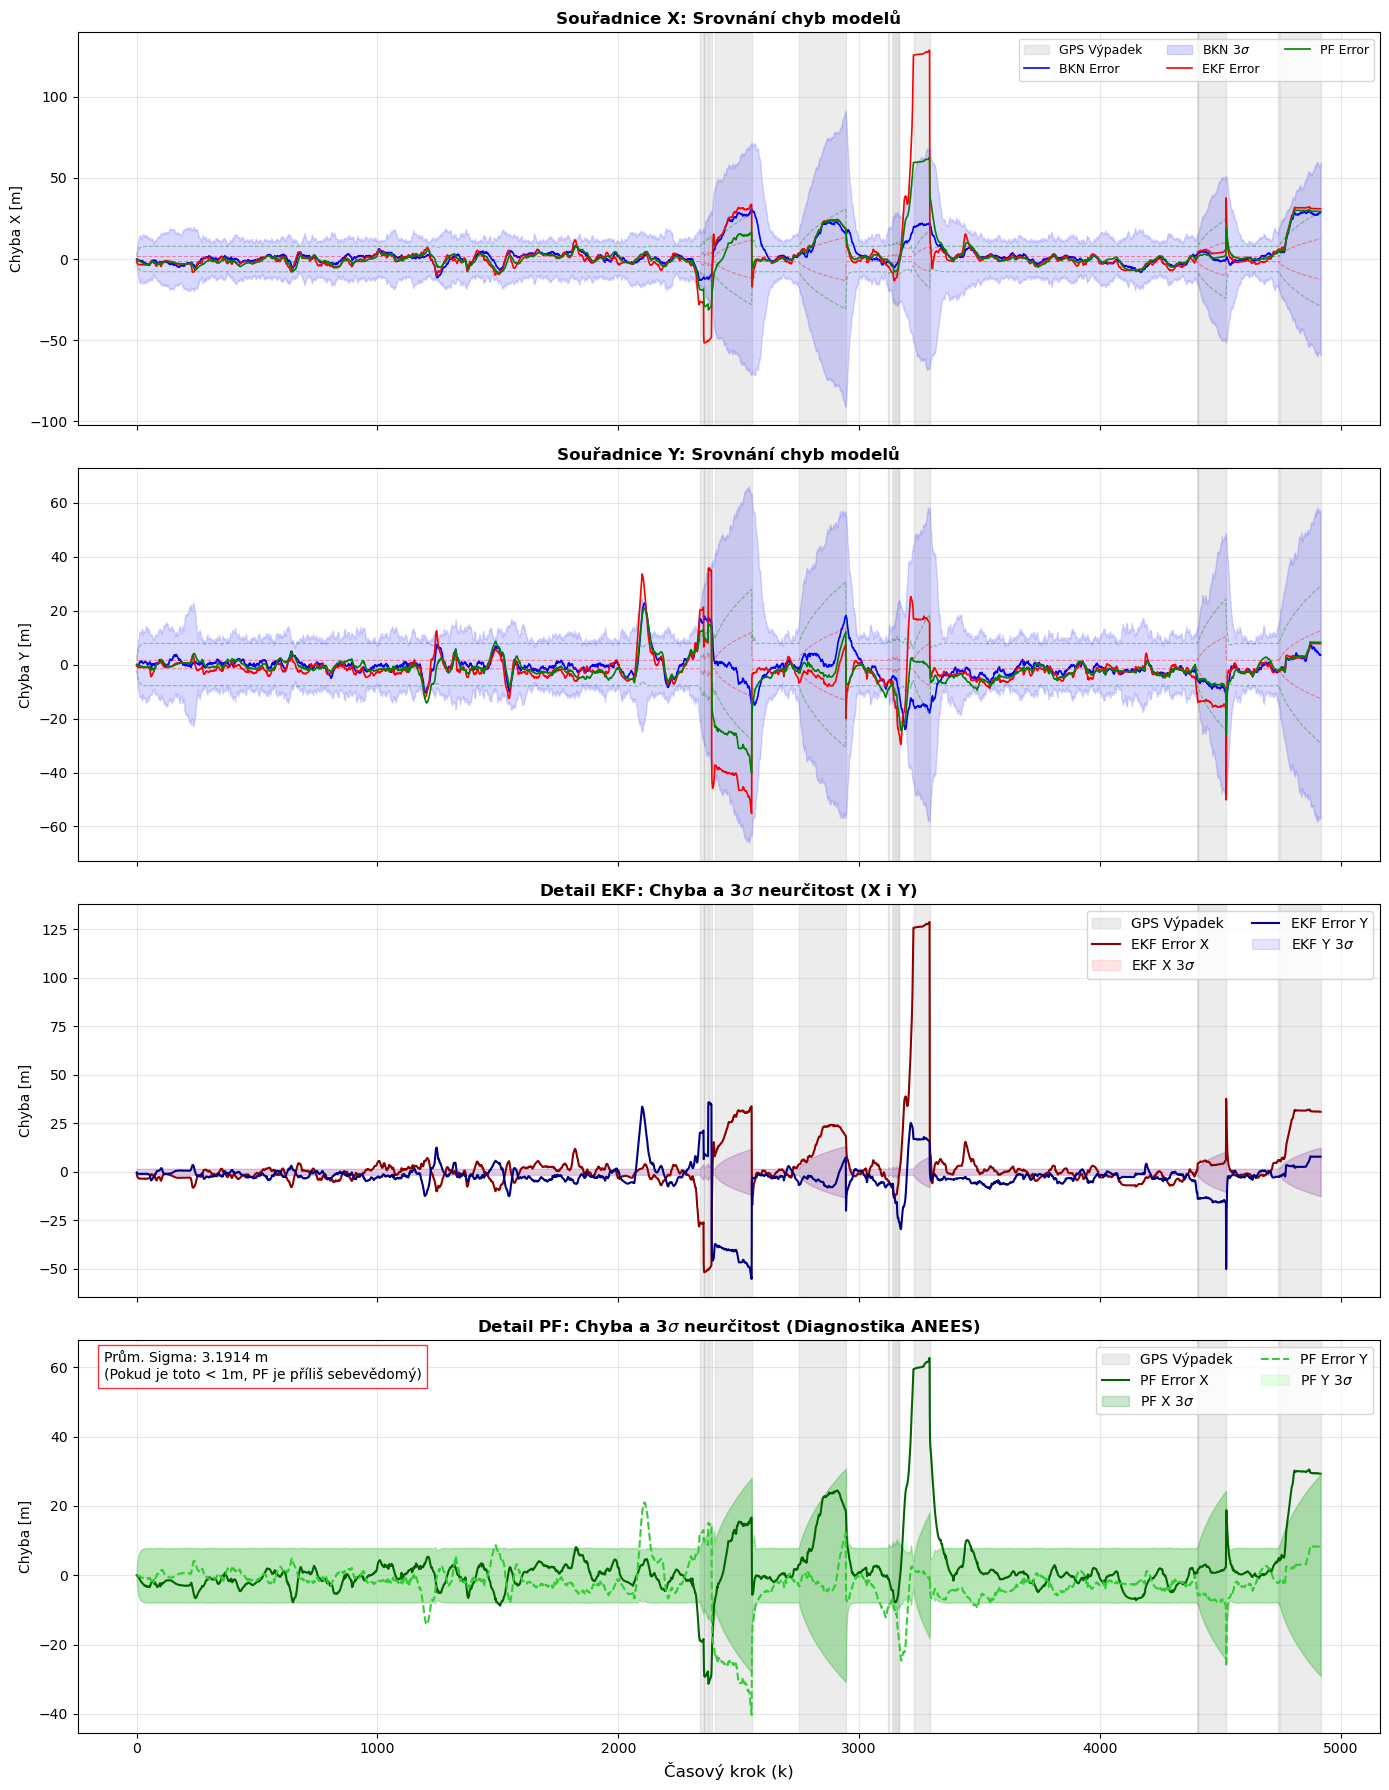

In [18]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

# ==============================================================================
# 1. KONFIGURACE A PŘÍPRAVA DAT (2. TRAJEKTORIE)
# ==============================================================================
TRAJ_IDX = 1  # Index druhé trajektorie
J_SAMPLES = 50 # Počet vzorků pro BKN
PLOT_SIGMA = 3 # 3-sigma (cca 99.7% confidence)

# Načtení dat trajektorie
traj_data = test_data_raw[TRAJ_IDX]
gt_raw = traj_data['ground_truth'].float().to(DEVICE)     # [T, 3] (x, y, theta)
gps_filtered = traj_data['filtered_gps'].float().to(DEVICE) # [T, 2] (s NaNs)
imu_raw = traj_data['imu'].float().to(DEVICE)
odo_raw = traj_data['filtered_wheel'].float().to(DEVICE)

# Input vector [v_left, v_right, ax, ay]
u_full = torch.stack((
    torch.nan_to_num(odo_raw[:, 0], nan=0.0),
    torch.nan_to_num(odo_raw[:, 1], nan=0.0),
    imu_raw[:, 2], 
    imu_raw[:, 3]
), dim=1).to(DEVICE)

T_len = gt_raw.shape[0]
x_true = gt_raw[:, :3]

# Init State
m = sys_model.state_dim
x0_vec = torch.zeros(m).to(DEVICE)
x0_vec[0] = x_true[0, 0]; x0_vec[1] = x_true[0, 1]
if m >= 3 and x_true.shape[1] >= 3: x0_vec[4] = x_true[0, 2]

# Maska výpadků GPS
gps_nan_mask = torch.isnan(gps_filtered[:, 0]).cpu().numpy()

# ==============================================================================
# 2. INFERENCE MODELŮ
# ==============================================================================
results = {}

# --- A. BKN ---
if 'state_bkn' in locals() or 'state_bkn' in globals():
    state_bkn.train()
    batch_x0 = x0_vec.unsqueeze(0).repeat(J_SAMPLES, 1)
    state_bkn.reset(batch_size=J_SAMPLES, initial_state=batch_x0)
    bkn_samples = [batch_x0.unsqueeze(1)]
    with torch.no_grad():
        for t in range(1, T_len):
            y_t = gps_filtered[t].unsqueeze(0).repeat(J_SAMPLES, 1)
            u_t = u_full[t].unsqueeze(0).repeat(J_SAMPLES, 1)
            x_est_j, _ = state_bkn.step(y_t, u_t)
            bkn_samples.append(x_est_j.unsqueeze(1))
    
    bkn_ens = torch.cat(bkn_samples, dim=1) 
    x_mean = torch.mean(bkn_ens, dim=0)
    centered = bkn_ens - x_mean.unsqueeze(0)
    centered = centered.permute(1, 2, 0)
    P_bkn = torch.bmm(centered, centered.transpose(1, 2)) / (J_SAMPLES - 1)
    
    results['BKN'] = {'x': x_mean.cpu().numpy(), 'P': P_bkn.cpu().numpy(), 'color': 'blue'}
    state_bkn.eval()

# --- B. EKF ---
if 'ekf_filter' in locals() or 'ekf_filter' in globals():
    try:
        res_ekf = ekf_filter.process_sequence(gps_filtered, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
        results['EKF'] = {'x': res_ekf['x_filtered'].cpu().numpy(), 
                          'P': res_ekf['P_filtered'].cpu().numpy(), 
                          'color': 'red'}
    except Exception as e: print(f"EKF chyba: {e}")

# --- C. PF (Particle Filter) ---
if 'pf_filter' in locals() or 'pf_filter' in globals():
    try:
        # Volání optimized PF (pozor na pojmenování argumentu u_sequence vs u_seq dle vaší implementace)
        res_pf = pf_filter.process_sequence(gps_filtered, u_sequence=u_full, Ex0=x0_vec, P0=sys_model.P0)
        results['PF'] = {'x': res_pf['x_filtered'].cpu().numpy(), 
                         'P': res_pf['P_filtered'].cpu().numpy(), 
                         'color': 'green'}
    except Exception as e: print(f"PF chyba: {e}")

# ==============================================================================
# 3. VIZUALIZACE (SROVNÁNÍ + DETAIL EKF + DETAIL PF)
# ==============================================================================
gt_np = x_true.cpu().numpy()

# Nastavení grafu: 4 řádky (X srovnání, Y srovnání, EKF Detail, PF Detail)
fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)
coords = ['X', 'Y']

# A) Příprava šedých zón (GPS výpadky)
is_nan = np.concatenate(([0], gps_nan_mask, [0]))
abs_diff = np.abs(np.diff(is_nan))
ranges = np.where(abs_diff == 1)[0].reshape(-1, 2)

# Funkce pro vykreslení pozadí výpadků
def plot_gps_outages(ax):
    for start, end in ranges:
        ax.axvspan(start, end, color='gray', alpha=0.15, label='GPS Výpadek' if start == ranges[0][0] else "")

# --- ŘÁDEK 1 a 2: SROVNÁNÍ VŠECH MODELŮ (X a Y) ---
for i in range(2):
    ax = axes[i]
    ax.set_title(f"Souřadnice {coords[i]}: Srovnání chyb modelů", fontsize=12, fontweight='bold')
    plot_gps_outages(ax)

    for name, res in results.items():
        # Chyba = GT - Odhad
        error = gt_np[:, i] - res['x'][:, i]
        
        # Obálka (3 sigma)
        sigma = np.sqrt(res['P'][:, i, i])
        bound_upper = PLOT_SIGMA * sigma
        bound_lower = -PLOT_SIGMA * sigma
        
        # Plot chyby
        ax.plot(error, color=res['color'], label=f'{name} Error', linewidth=1.2)
        
        # Pro BKN vykreslíme i výplň
        if name == 'BKN':
            ax.fill_between(range(T_len), bound_lower, bound_upper, color=res['color'], alpha=0.15, label=f'BKN {PLOT_SIGMA}$\sigma$')
        else:
            # Pro ostatní jen čárkovanou čáru, aby se to nepřeplácalo
            ax.plot(bound_upper, color=res['color'], linestyle='--', linewidth=0.8, alpha=0.4)
            ax.plot(bound_lower, color=res['color'], linestyle='--', linewidth=0.8, alpha=0.4)

    ax.set_ylabel(f"Chyba {coords[i]} [m]")
    ax.grid(True, alpha=0.3)
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=3, fontsize=9)

# --- ŘÁDEK 3: EKF DETAIL ---
ax_ekf = axes[2]
ax_ekf.set_title(f"Detail EKF: Chyba a {PLOT_SIGMA}$\sigma$ neurčitost (X i Y)", fontsize=12, fontweight='bold')
plot_gps_outages(ax_ekf)

if 'EKF' in results:
    res = results['EKF']
    
    # Chyby X a Y
    err_x = gt_np[:, 0] - res['x'][:, 0]
    err_y = gt_np[:, 1] - res['x'][:, 1]
    
    # Sigmy X a Y
    sig_x = np.sqrt(res['P'][:, 0, 0])
    sig_y = np.sqrt(res['P'][:, 1, 1])
    
    # Vykreslení X (Červená)
    ax_ekf.plot(err_x, color='darkred', label='EKF Error X', linewidth=1.5)
    ax_ekf.fill_between(range(T_len), -PLOT_SIGMA*sig_x, PLOT_SIGMA*sig_x, color='red', alpha=0.1, label=f'EKF X {PLOT_SIGMA}$\sigma$')
    
    # Vykreslení Y (Modrá)
    ax_ekf.plot(err_y, color='navy', label='EKF Error Y', linewidth=1.5, linestyle='-')
    ax_ekf.fill_between(range(T_len), -PLOT_SIGMA*sig_y, PLOT_SIGMA*sig_y, color='blue', alpha=0.1, label=f'EKF Y {PLOT_SIGMA}$\sigma$')
    
    ax_ekf.legend(loc='upper right', ncol=2, fontsize=10)
    ax_ekf.set_ylabel("Chyba [m]")
else:
    ax_ekf.text(0.5, 0.5, "EKF data nejsou k dispozici", ha='center', va='center', transform=ax_ekf.transAxes)

ax_ekf.grid(True, alpha=0.3)

# --- ŘÁDEK 4: PF DETAIL (Analýza ANEES) ---
ax_pf = axes[3]
ax_pf.set_title(f"Detail PF: Chyba a {PLOT_SIGMA}$\sigma$ neurčitost (Diagnostika ANEES)", fontsize=12, fontweight='bold')
plot_gps_outages(ax_pf)

if 'PF' in results:
    res = results['PF']
    
    # Chyby X a Y
    err_x = gt_np[:, 0] - res['x'][:, 0]
    err_y = gt_np[:, 1] - res['x'][:, 1]
    
    # Sigmy X a Y (Očekáváme, že budou velmi malé, což způsobuje vysoké ANEES)
    sig_x = np.sqrt(res['P'][:, 0, 0])
    sig_y = np.sqrt(res['P'][:, 1, 1])
    
    # Vykreslení X (Tmavě zelená)
    ax_pf.plot(err_x, color='darkgreen', label='PF Error X', linewidth=1.5)
    ax_pf.fill_between(range(T_len), -PLOT_SIGMA*sig_x, PLOT_SIGMA*sig_x, color='green', alpha=0.2, label=f'PF X {PLOT_SIGMA}$\sigma$')
    
    # Vykreslení Y (Limetková)
    ax_pf.plot(err_y, color='limegreen', label='PF Error Y', linewidth=1.5, linestyle='--')
    ax_pf.fill_between(range(T_len), -PLOT_SIGMA*sig_y, PLOT_SIGMA*sig_y, color='lime', alpha=0.1, label=f'PF Y {PLOT_SIGMA}$\sigma$')
    
    # Výpis průměrné odhadované chyby pro kontrolu
    avg_sigma = np.mean(sig_x + sig_y) / 2
    ax_pf.text(0.02, 0.9, f"Prům. Sigma: {avg_sigma:.4f} m\n(Pokud je toto < 1m, PF je příliš sebevědomý)", 
               transform=ax_pf.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))
    
    ax_pf.legend(loc='upper right', ncol=2, fontsize=10)
    ax_pf.set_ylabel("Chyba [m]")
else:
    ax_pf.text(0.5, 0.5, "PF data nejsou k dispozici", ha='center', va='center', transform=ax_pf.transAxes)

ax_pf.grid(True, alpha=0.3)
axes[-1].set_xlabel("Časový krok (k)", fontsize=12)

plt.tight_layout()
plt.show()